# Creating Sines

In [1]:
import os, sys
sys.path.insert(1, '../stella/')
sys.path.insert(1, '../scripts/')
import numpy as np
from utils import *
import models
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob
from tqdm import tqdm
import wotan
import lightkurve as lk
import stella
import pandas as pd
import random
import batman 
import warnings
from sklearn.preprocessing import MinMaxScaler, RobustScaler

/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


## Load lightcurves

In [2]:
files = glob('../data/eleanor/s0018/*.fits', recursive=True)
#files = glob('../data/kepler/Q0/*.fits',recursive=True)
random.shuffle(files)

## Functions

In [3]:
def calculate_timestep(table):
    """
    Function: Calculates the median value of the time differences between data points in a given table. 
    Provides an estimate of the timestep (or time delta) between consecutive data points.

    Parameters:
    :table (array or pandas.DataFrame): The input table containing time-series data.

    Returns:
    :dt (float): The estimated time interval or timestep between consecutive data points."""

    try:
        dt = [ table[i+1][0] - table[i][0] for i in range(len(table)-1) ] # calculates difference between (ith+1) - (ith) point 
        dt.sort()
        return dt[int(len(dt)/2)] # median of them.
    except:
        return np.median(np.diff(table['time'])) ## change this to account for any time column names

    

def clean_data(table):
    """
    Function: Interpolating missing data points, ensuring equal time gaps between points. 
    Returns five numpy arrays: time, flux, quality, real, and flux_error. Real is 0 if data point interpolated, 1 otherwise.

    Parameters:
    :table (astropy.table.table): The input table containing time-series data.
    
    Returns:
    :time (numpy.ndarray): An array of timestamps for each data point, including the interpolated points.
    :flux (numpy.ndarray): An array of flux values for each data point, including the interpolated points.
    :quality (numpy.ndarray): An array indicating the quality of each data point, including the interpolated points.
    :real (numpy.ndarray): An array indicating whether each data point is real (1) or interpolated (0).
    :flux_error (numpy.ndarray): An array of flux error values for each data point, including the interpolated points."""


    time = []
    flux = []
    quality = []
    real = []
    flux_error = []
    timestep = calculate_timestep(table)


    ### this scale factor ensures that you can use any cadence of lightcurves. 48 cadences = 1 day.
    factor = ((1/48)/timestep)

    for row in table:
        ti, fi, qi, fei = row

        if len(time) > 0:
            steps = int(round( (ti - time[-1])/timestep * factor)) # (y2-y1)/(x2-x1)
            if steps > 1:
                fluxstep = (fi - flux[-1])/steps
                fluxerror_step = (fei - flux_error[-1])/steps

                # For small gaps, pretend interpolated data is real.
                if steps > 2:
                    set_real=0
                else:
                    set_real=1

                for _ in range(steps-1):
                    time.append(timestep + time[-1])
                    flux.append(fluxstep + flux[-1])
                    flux_error.append(fluxerror_step + flux_error[-1])

                    quality.append(0)
                    real.append(set_real)
        time.append(ti)
        flux.append(fi)
        quality.append(qi)
        real.append(1)
        flux_error.append(fei)

    return [np.array(x) for x in [time,flux,quality,real,flux_error]]

def scale_relative_to_baseline(flux):
    baseline = np.median(flux)  # or use a more sophisticated method to determine baseline
    scaled_flux = (flux - baseline) / baseline
    return (scaled_flux - np.min(scaled_flux)) / (np.max(scaled_flux) - np.min(scaled_flux))

def normalise_depth(flux):
    median = np.median(flux)
    min_flux = np.min(flux)
    abs_depth = median - min_flux
    depth_normalised_lightcurve = ((flux - median) / abs_depth + 1)
    return depth_normalised_lightcurve

# Create sine waves

In [4]:
name = 'sines'
folder = f'../models/{name}' 

In [92]:
from scipy.signal import find_peaks, find_peaks_cwt

def inject_sine_waves(time, flux, num_waves=1, min_period=1.5, max_period=3, min_amplitude=0.01, max_amplitude=0.01):
    for _ in range(num_waves):
        period = np.random.uniform(min_period, max_period)
        amplitude = np.random.uniform(min_amplitude, max_amplitude)
        phase = np.random.uniform(0, 2*np.pi)
        
        sine_wave = amplitude * np.sin(2 * np.pi * time / period + phase)
        
        flux *= (1 + sine_wave)
    
    return sine_wave,flux

# def find_bottom_peaks(time, flux, prominence_factor=0.01, min_distance_days=1.5):
#     inverted_flux = -flux

#     # Calculate prominence based on median normalization
#     prominence = prominence_factor  # Since median flux is 1.0
    
#     # Convert min_distance_days to number of data points
#     time_step = np.median(np.diff(time))
#     distance = 144 #(min_distance_days / time_step)
    
#     # Use scipy's find_peaks function with adaptive parameters
#     peaks, _ = find_peaks(inverted_flux, prominence=prominence, distance=distance)
    
#     # Get the times corresponding to these peaks (troughs in original data)
#     trough_times = time[peaks]
    
#     return trough_times

from scipy.signal import find_peaks, savgol_filter


def find_troughs(time, flux, min_distance_days=1, prominence_factor=0.01):
    # Invert the flux to turn troughs into peaks
    inverted_flux = -flux

    # Smooth the inverted flux
    smoothed_flux = savgol_filter(inverted_flux, window_length=11, polyorder=3)

    # Estimate signal properties
    amplitude = np.max(smoothed_flux) - np.min(smoothed_flux)
    timestep = np.median(np.diff(time))
    distance = int(min_distance_days / timestep)

    # Adjust prominence based on amplitude
    prominence = max(prominence_factor, amplitude * 0.1)

    # Find peaks (troughs in original signal)
    troughs, properties = find_peaks(smoothed_flux, 
                                     prominence=prominence, 
                                     distance=distance, 
                                     width=5)

    # Calculate depth and width of each trough
    depths = properties['prominences']
    widths = properties['widths'] * timestep  # Convert width to time units

    return time[troughs], depths, widths

In [93]:
np.random.shuffle(files)

In [94]:
find_troughs(time,ftest)

(array([1791.53384874, 1796.57563646, 1800.63822103, 1804.30495371,
        1808.38834865, 1812.45089709]),
 array([0.09449434, 0.02088606, 0.02664804, 0.01897401, 0.02864629,
        0.02310169]),
 array([0.34192838, 2.02872549, 1.67824024, 1.39109629, 1.81112994,
        1.75421783]))

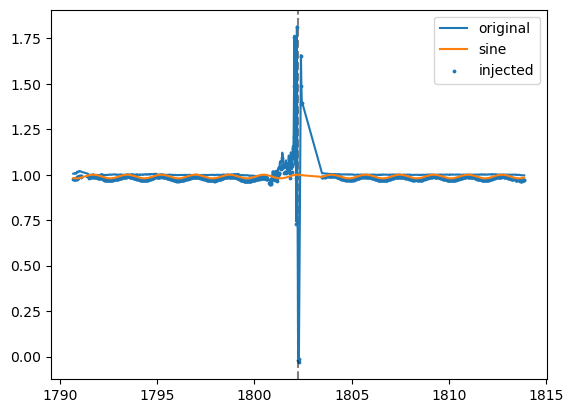

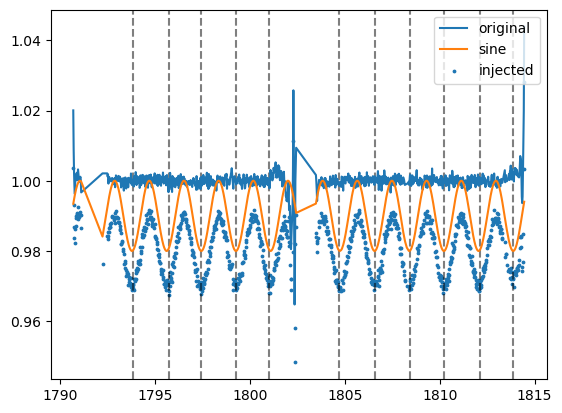

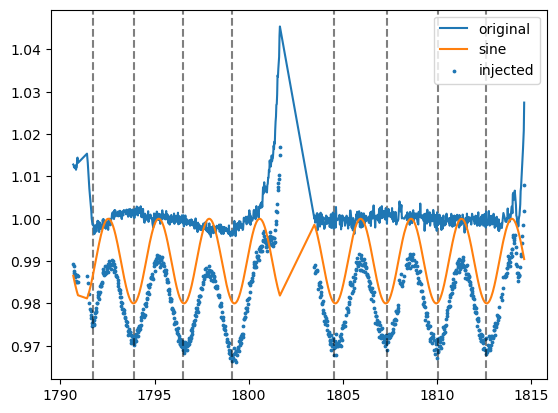

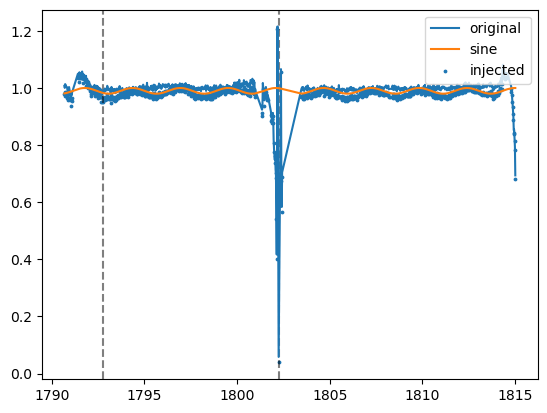

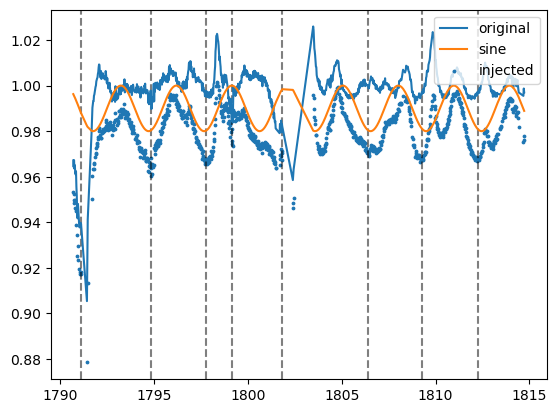

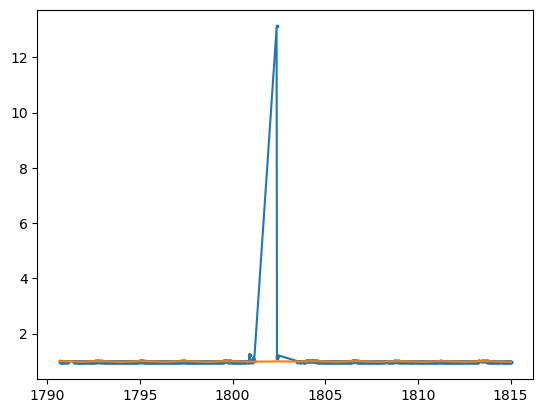

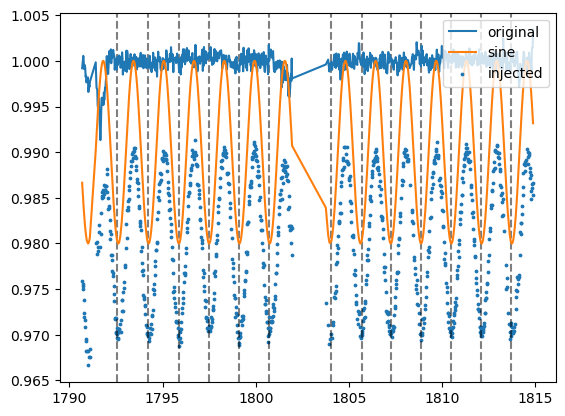

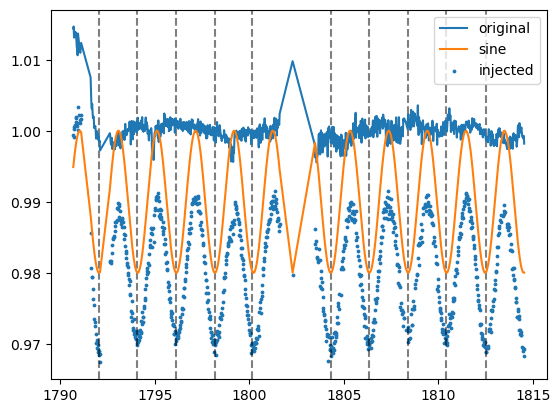

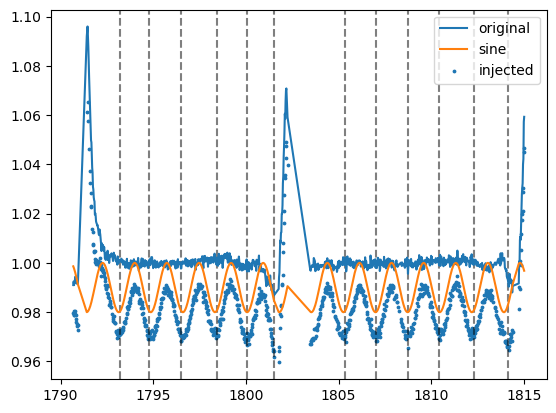

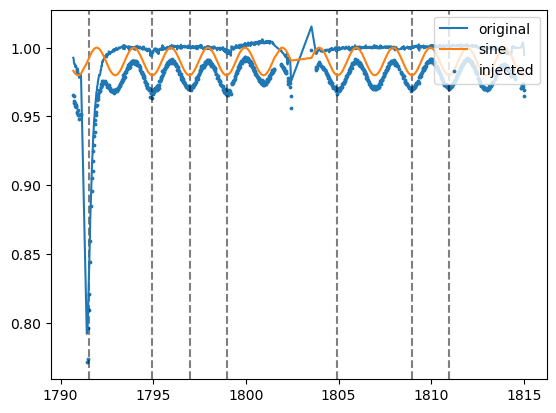

In [95]:
for i in files[0:10]:
    lc, lc_info = import_lightcurve(i)

    time, flux = np.array(lc['TIME']), (np.array(lc['PCA_FLUX'])/np.nanmedian(lc['PCA_FLUX']))
    sine, ftest = inject_sine_waves(time, flux.copy(),num_waves=1)
    bottom_peaks, _, _ = find_troughs(time,ftest)
    plt.plot(time,flux,label='original')
    plt.plot(time,(sine+1)-0.01,label='sine')
    plt.scatter(time,ftest-0.02,label='injected',s=3)
    for peak_time in bottom_peaks:
        plt.axvline(x=peak_time, color='black', linestyle='--', alpha=0.5,zorder=1)
        plt.legend(loc='upper right')
    plt.show()

In [125]:
lc, lc_info = import_lightcurve(files[92], drop_bad_points=True)

In [43]:
time, flux = np.array(lc['TIME']), (np.array(lc['PCA_FLUX'])/np.nanmedian(lc['PCA_FLUX']))

In [38]:
ftest = inject_sine_waves(time, flux.copy(),num_waves=2)
bottom_peaks = find_bottom_peaks(time,ftest)

TypeError: bad operand type for unary -: 'tuple'

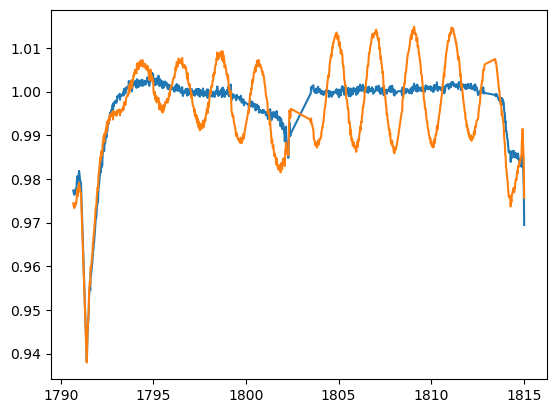

In [9]:
plt.plot(time,flux)
plt.plot(time,ftest)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


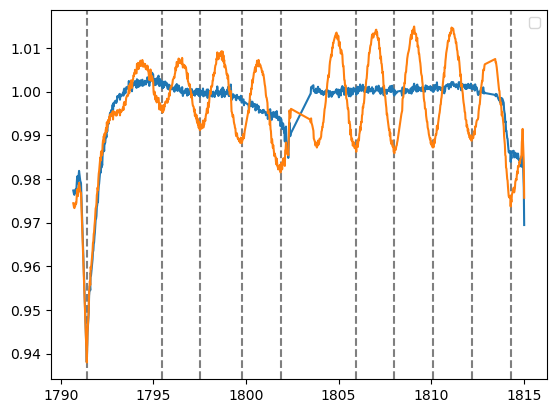

In [10]:
#ftest2 = inject_sine_waves2(time, flux.copy(),num_waves=5)
plt.plot(time,flux)
plt.plot(time,ftest)
for peak_time in bottom_peaks:
    plt.axvline(x=peak_time, color='black', linestyle='--', alpha=0.5,zorder=1)
plt.legend(loc='upper right')